In [166]:
import os
import psycopg2
from dotenv import load_dotenv
from sshtunnel import SSHTunnelForwarder
import time
import pandas as pd
import numpy as np
import statsmodels
import seaborn as sns
%matplotlib inline

In [4]:
# Load environment variables from .env file
load_dotenv("environment_variables.env")
psql_pw = os.getenv("PSQL_PW")

# Get data
## DB Connection

In [5]:
# Connect to AWS RDS instance through AWS EC2 instance

# SSH parameters
bastion_host = 'ec2-34-224-93-62.compute-1.amazonaws.com'
bastion_user = 'ec2-user'
bastion_key = 'C:\\Users\\detto\\Documents\\ec2-key-pair.pem'

# RDS parameters
rds_host = 'youtubeviewprediction.cd0c8oow2pnr.us-east-1.rds.amazonaws.com'
rds_user = 'postgres'
rds_password = psql_pw
rds_database = 'YouTubeViewPrediction'
rds_port = 5432

try:
    # Create an SSH tunnel
    tunnel = SSHTunnelForwarder(
        (bastion_host, 22),
        ssh_username=bastion_user,
        ssh_pkey=bastion_key,
        remote_bind_address=(rds_host, rds_port),
        local_bind_address=('localhost', 6543)  # Choose a local port for the tunnel
    )

    # Start the tunnel
    tunnel.start()

    # Connect to PostgreSQL through the tunnel
    conn = psycopg2.connect(
        database=rds_database,
        user=rds_user,
        password=rds_password,
        host=tunnel.local_bind_host,
        port=tunnel.local_bind_port
    )

    # Create a cursor object
    cursor = conn.cursor()

    # Execute a SQL query
    cursor.execute("SELECT version();")

    # Fetch result
    record = cursor.fetchone()
    print("You are connected to - ", record)

except (Exception, psycopg2.Error) as error:
    print("Error while connecting to PostgreSQL", error)
    tunnel.stop()

You are connected to -  ('PostgreSQL 16.1 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 7.3.1 20180712 (Red Hat 7.3.1-12), 64-bit',)


## Turn SQL tables in to Pandas dataframes

In [6]:
video_fact = pd.read_sql_query("SELECT * FROM video_fact", conn)
video_dim = pd.read_sql_query("SELECT * FROM video_dim", conn)
channel_fact = pd.read_sql_query("SELECT * FROM channel_fact", conn)
channel_dim = pd.read_sql_query("SELECT * FROM channel_dim", conn)
categories_dim = pd.read_sql_query("SELECT * FROM categories_dim", conn)

In [7]:
conn.close()
cursor.close()
tunnel.stop()

# EDA
## video_fact

In [8]:
video_fact.shape

(59938, 5)

In [9]:
video_fact.dtypes

collected_at    datetime64[ns]
video_id                object
num_views                int64
num_likes                int64
num_comments             int64
dtype: object

In [10]:
video_fact.describe()

,num_views,num_likes,num_comments
count,5.993800e+04,5.993800e+04,59938.000000
mean,2.978206e+06,1.175382e+05,7843.273950
std,1.161440e+07,5.392433e+05,30220.423922
min,3.034000e+04,0.000000e+00,0.000000
25%,4.699372e+05,1.300250e+04,980.000000
50%,9.615420e+05,3.159450e+04,2446.000000
75%,2.064414e+06,7.694400e+04,4984.000000
max,2.158514e+08,8.275155e+06,385935.000000


In [11]:
video_fact[["collected_at", "video_id"]].nunique()

collected_at    130
video_id        721
dtype: int64

In [12]:
video_fact.isna().sum()

collected_at    0
video_id        0
num_views       0
num_likes       0
num_comments    0
dtype: int64

In [17]:
id_counts = video_fact["video_id"].value_counts()
id_counts

laNA2HgwYXU    130
uhbDfi7Ee7k    130
30ybT5NQ9pg    130
GHtIxjKPP9w    130
j7YgKocz2W4    130
              ... 
QndJKA8mmu4      2
-pJgPg5bBJ4      2
12fL720Th2A      2
demGf8hvuvE      2
WhhovQ7HW4k      1
Name: video_id, Length: 721, dtype: int64

Text(0, 0.5, 'Number of Time Points Collected')

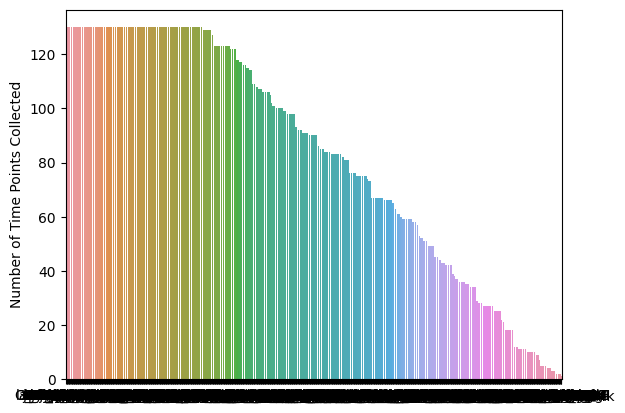

In [30]:
ax = sns.barplot(x=id_counts.index, y=id_counts)
ax.set_ylabel("Number of Time Points Collected")

In [22]:
id_counts2 = id_counts.value_counts()
id_counts2.sort_index(inplace=True, ascending=False)
id_counts2

130    200
123     24
67      18
75      16
83      15
      ... 
102      1
121      1
125      1
127      1
1        1
Name: video_id, Length: 82, dtype: int64

Text(0, 0.5, 'Number of Videos')

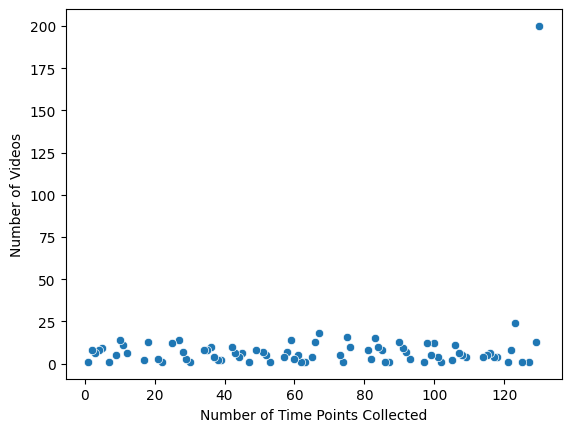

In [29]:
ax = sns.scatterplot(x=id_counts2.index, y=id_counts2)
ax.set_xlabel("Number of Time Points Collected")
ax.set_ylabel("Number of Videos")

### Look at some individual time series

d1LtD1ssW9U
(18, 5)


<AxesSubplot: xlabel='collected_at', ylabel='num_views'>

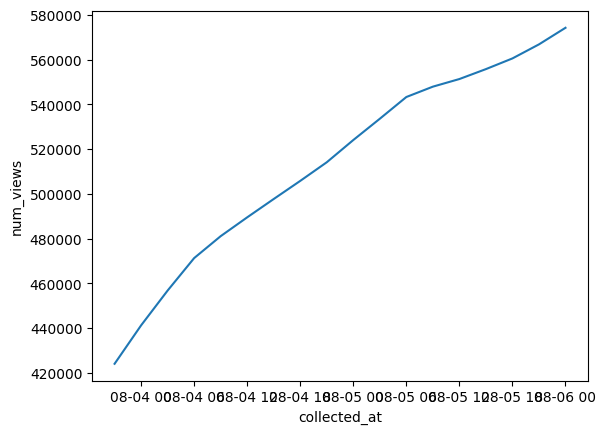

In [137]:
vid_id = id_counts.sample(1).index[0]
print(vid_id)
vid_id_data = video_fact.loc[video_fact["video_id"] == vid_id]
print(vid_id_data.shape)
sns.lineplot(x=vid_id_data["collected_at"], y=vid_id_data["num_views"])

NfMdvee5HoY
(130, 1)


<AxesSubplot: xlabel='collected_at', ylabel='num_views'>

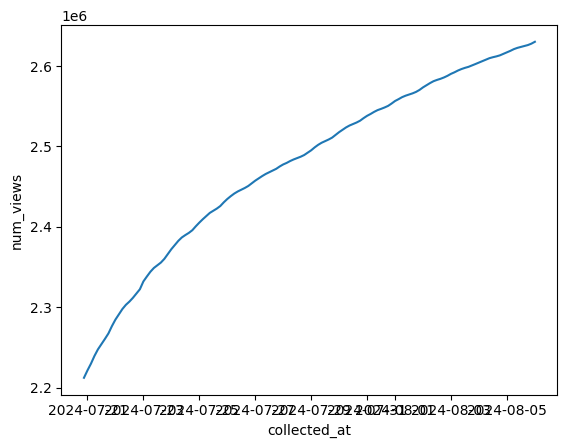

In [156]:
id = id_counts.sample(1).index[0]
print(vid_id)
id_data = video_fact.loc[video_fact["video_id"] == id, ["collected_at", "num_views"]]
id_data.set_index("collected_at", inplace=True)
print(id_data.shape)
sns.lineplot(x=id_data.index, y=id_data["num_views"])

<AxesSubplot: xlabel='collected_at', ylabel='num_views'>

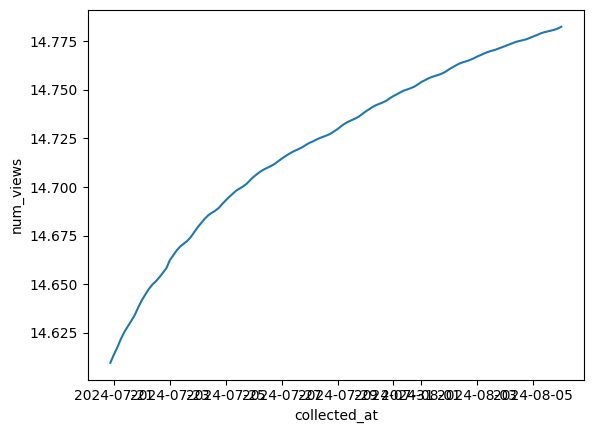

In [157]:
id_data_log = np.log(id_data)
sns.lineplot(x=id_data_log.index, y=id_data_log["num_views"])

<AxesSubplot: xlabel='collected_at', ylabel='num_views'>

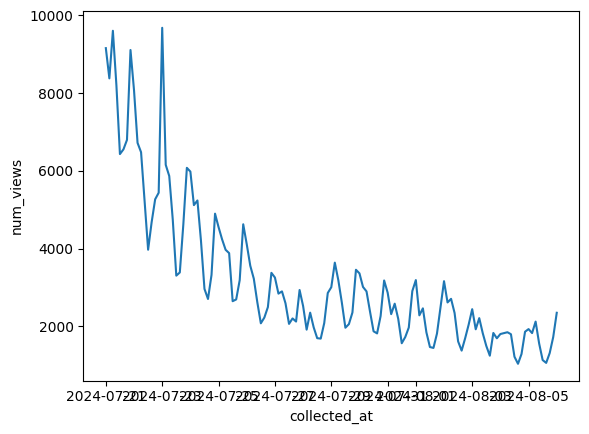

In [162]:
id_data_diff = id_data.diff(1).dropna()
sns.lineplot(x=id_data_diff.index, y=id_data_diff["num_views"])

In [168]:
from statsmodels.tsa.stattools import adfuller
# Perform ADF test
adf_result = adfuller(id_data_diff["num_views"].dropna())
print('p-value:', adf_result[1])

p-value: 0.0008971593465888943


<AxesSubplot: xlabel='collected_at', ylabel='num_views'>

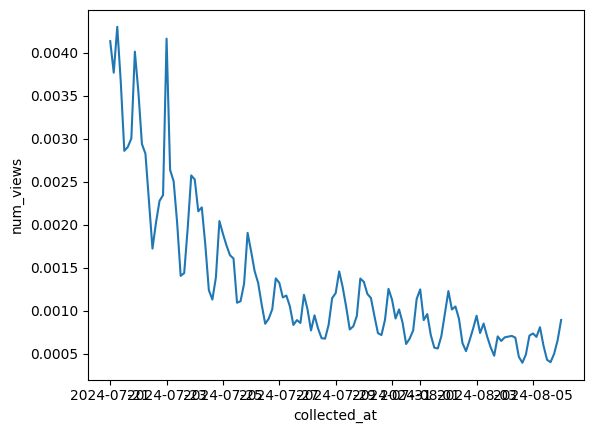

In [169]:
id_data_logdiff = np.log(id_data).diff(1).dropna()
sns.lineplot(x=id_data_logdiff.index, y=id_data_logdiff["num_views"])

In [170]:
# Perform ADF test
adf_result = adfuller(id_data_logdiff["num_views"].dropna())
print('p-value:', adf_result[1])

p-value: 0.0003944937222349858
